# Parte 5: Similitud entre productos

En la etapa 5 del reto, se realizó una exploración de estrategias para encontrar la similitud entre productos. Entendiendo la naturaleza de los datos y sabiendo que tenemos información asociada a diferentes características de cada producto, se decidió realizar una comparación de distancias entre los mismos. Usando la distancia de Gower se puede encontrar la máxima y mínima distancia existente entre productos. 
Así, mediante este notebook se abordaron estrategias para encontrar productos similares mediante clustering y la distancia de Gower

In [20]:
import pandas as pd
import regex,unidecode,urllib
import numpy as np
import os, glob, json, csv, itertools
from pathlib import Path  
from IPython.display import Image
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil, sys
from wordcloud import WordCloud
import PIL
from scipy import spatial
import tensorflow as tf
import keras
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
import pandas as pd 
import numpy as np
import gower
from sklearn.metrics.cluster import rand_score
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import AgglomerativeClustering


In [2]:
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import DistanceMetric

In [3]:
CWD = os.getcwd()

#### Características de los productos

In [4]:
filepath = Path(CWD+'/dataset_sub_cats.csv')  
df_subcat = pd.read_csv(filepath)
CATEGORIAS_LISTA = list(df_subcat['categoria'].unique())

#### Productos con sus características

In [6]:
filepath = Path(CWD+'/dataset_products_feats.csv')  
df_products_prev = pd.read_csv(filepath)

In [7]:
df_products_prev.head(5)

,centroid_name,centroid_brand,price,centroid_image,labelgroup
0,0.000213,0.0,13999.00,0.111302,3
1,0.000196,0.0,17787.00,0.117811,235
2,0.000257,0.0,6059.99,0.086682,3
3,0.000213,0.0,13999.00,0.111302,339
4,0.000113,0.0,1150.00,0.123773,235


# Estructura de los productos

* Integrar vectorización de textos y de imágenes 
* La similitud o integración de estas características serán la entrada para el cálculo de similitud entre productos
* Se generará una etiqueta (labelgroup) que está compuesta por la etiqueta de la categoría y subcategoría de cada producto
* Labelgroup permitirá hacer el primer filtro al buscar la similitud entre productos

# Cálculo de similitud entre productos mediante la distancia de Gower

Una de las funciones de distancia más famosas que se pueden aplicar a datos categóricos, es la función de distancia de Gower, que usaremos en este notebook para agrupar algunos datos en diferentes grupos de productos

## Cálculo de similitud: Distancia de Gower

In [8]:
# Calculate Gower's distance matrix
gower_mat = gower.gower_matrix(df_products_prev,  cat_features = [False, False, False, False, True])
gower_arr = np.nan_to_num(np.array(gower_mat))

In [9]:
df_gower = pd.DataFrame(gower_mat)
df_gower

,0,1,2,3,4,5,6,7,8,9,...,19261,19262,19263,19264,19265,19266,19267,19268,19269,19270
0,0.000000,0.219193,0.062876,0.200000,0.270667,0.110401,0.310003,0.244842,0.207478,0.244888,...,0.263713,0.298995,0.211215,0.253243,0.223681,0.236542,0.277367,0.269182,0.217949,0.284654
1,0.219193,0.000000,0.282069,0.219193,0.051488,0.308093,0.311730,0.264026,0.213823,0.236568,...,0.282906,0.301317,0.228737,0.271706,0.211772,0.217363,0.279689,0.253643,0.228101,0.282332
2,0.062876,0.282069,0.000000,0.262876,0.333514,0.156098,0.372878,0.247946,0.268246,0.307743,...,0.284603,0.280503,0.253332,0.295798,0.286528,0.299389,0.301413,0.332058,0.254058,0.344243
3,0.200000,0.219193,0.262876,0.000000,0.270667,0.310401,0.310003,0.244842,0.207478,0.244888,...,0.263713,0.298995,0.211215,0.253243,0.223681,0.236542,0.277367,0.269182,0.217949,0.284654
4,0.270667,0.051488,0.333514,0.270667,0.000000,0.339829,0.281204,0.315509,0.265269,0.225779,...,0.334345,0.339925,0.280187,0.323150,0.246986,0.234126,0.317535,0.287045,0.279589,0.314122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19266,0.236542,0.217363,0.299389,0.236542,0.234126,0.307993,0.311830,0.281384,0.231143,0.236634,...,0.300219,0.305799,0.246062,0.289024,0.212866,0.000000,0.283409,0.253597,0.245464,0.282286
19267,0.277367,0.279689,0.301413,0.277367,0.317535,0.302299,0.271473,0.306821,0.284817,0.291772,...,0.216847,0.222391,0.266152,0.224124,0.270548,0.283409,0.000000,0.247899,0.295317,0.276588
19268,0.269182,0.253643,0.332058,0.269182,0.287045,0.254563,0.279939,0.314015,0.263812,0.290210,...,0.247462,0.269527,0.278726,0.236262,0.065415,0.253597,0.247899,0.000000,0.077999,0.028689
19269,0.217949,0.228101,0.254058,0.217949,0.279589,0.302173,0.327357,0.236016,0.214320,0.253810,...,0.278469,0.316945,0.229165,0.271192,0.032603,0.245464,0.295317,0.077999,0.000000,0.090185


* La matriz representa la distancia entre cada uno de los productos de la base de datos
* Una distancia de 0 indica que los productos son idénticos

## Búsqueda del número óptimo de clusters

In [46]:
df_products_clus = df_products_prev.copy(deep=True).dropna()

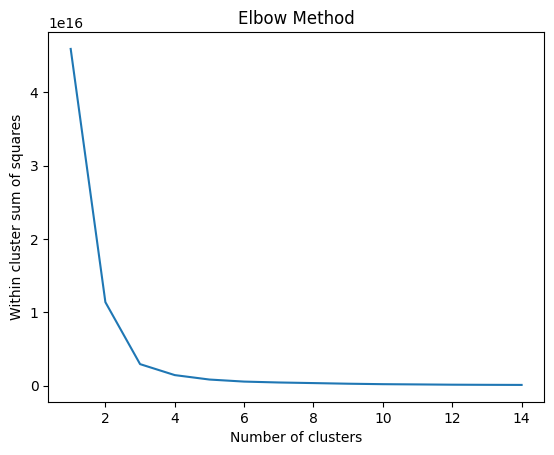

In [49]:
ws = []
for i in range(1,15):
    model = KMeans(n_clusters=i,
                  init = 'k-means++',
                  max_iter = 300, 
                  n_init=10,
                  random_state=0)
    model.fit(df_products_clus)
    ws.append(model.inertia_)
#show elbow plot
plt.plot(range(1,15),ws)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within cluster sum of squares')
plt.show()

### Kmeans

In [52]:
kmeans = KMeans(n_clusters=3).fit(np.array(gower_arr))
centroids = kmeans.cluster_centers_
labels = kmeans.predict(np.array(gower_arr))
labels

array([1, 1, 1, ..., 0, 1, 0], dtype=int32)

<AxesSubplot:ylabel='None'>

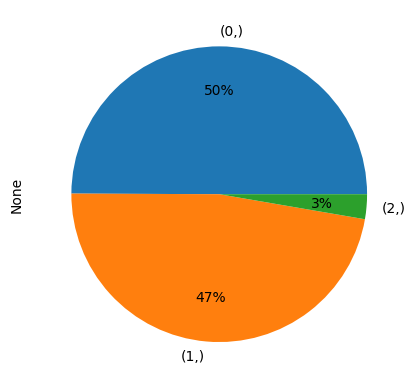

In [53]:
df_res = pd.DataFrame(labels)
df_res.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

In [54]:
df_products_prev['clus'] = labels

In [55]:
#Calcular métricas de desempeño

## Alternativa: clustering con filtro previo 

### Filtrar por labelgroup

In [57]:
df_products_filt = df_products[['name_vector','brand_vector','price','image_feature','labelgroup']]
list_labels = list(df_products_filt['labelgroup'].unique())

In [65]:
df_i = pd.DataFrame(df_products_filt[df_products_filt['labelgroup']==list_labels[0]])
df_i['centroid_name'] = [np.mean(n) for n in df_i['name_vector']]
df_i['centroid_brand'] = [np.mean(n) for n in df_i['brand_vector']]
df_i['centroid_image'] = [np.mean(n) for n in df_i['image_feature']]
df_i = df_i[['centroid_name','centroid_brand','centroid_image','labelgroup','price']]

### Calcular la distancia de Gower para el nuevo dataframe

In [66]:
gower_m_i =gower.gower_matrix(df_i)

In [67]:
# first product
prod_i =gower.gower_matrix(df_i)[0]
prod_i

array([0.        , 0.13467252, 0.1572486 , 0.2813307 , 0.15877707,
       0.26269484, 0.10920186, 0.2547721 , 0.1888526 , 0.11543649,
       0.07757255, 0.26161423, 0.2362766 , 0.13871731, 0.13244508,
       0.1067074 , 0.25602782, 0.29725757, 0.29530954, 0.24516314,
       0.36669406, 0.1346462 , 0.10638318, 0.09371947, 0.18787609,
       0.10915117, 0.2216981 , 0.1914403 , 0.06965397, 0.11620469,
       0.18599392, 0.27390644, 0.3110042 , 0.11085524, 0.11081959,
       0.27839252, 0.09420162, 0.09064697, 0.23483625, 0.0878252 ,
       0.02286327, 0.12086874, 0.17527907, 0.22940134, 0.09715415,
       0.09920938, 0.15316369, 0.28783208, 0.12480713, 0.13975154],
      dtype=float32)

In [69]:
df_i[prod_i==min(prod_i[prod_i!= min(prod_i)])] #minimum distance
df_i[prod_i==max(prod_i)] #max distance

,centroid_name,centroid_brand,centroid_image,labelgroup,price
1016,0.000311,0.0,0.117172,03,15007.0


### Clusters

In [ ]:
X = np.array(df_products_prev[['centroid_image','centroid_name','centroid_brand','price']])
Y = np.array(df_products_prev['labelgroup'])
X_arr = np.array(X)
X_arr = np.nan_to_num(X_arr)

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_arr).score(X_arr) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [100]:
kmeans = KMeans(n_clusters=5).fit(np.array(gower_m_i))
centroids = kmeans.cluster_centers_


In [102]:
from mpl_toolkits.mplot3d import Axes3D

labels = kmeans.predict(np.array(gower_m_i))
df_i['cluster'] = labels

In [113]:
np.array(df_i[df_i['cluster']==i])[:,0]

array([0.00031594261032750055, 0.0003623041336453612,
       0.00034186816741827754, 0.00039930287750545603,
       0.0003350333920288445, 0.0003623041336453612,
       0.0003756966381314468, 0.0003426206882256562,
       0.0003967004070859011, 0.0002407231994370668,
       0.00027619530467347663, 0.0002479603933920727,
       0.0003770089178959259, 0.0002931115955408384,
       0.00040857742673596045, 0.0003815145483594131,
       0.0003197941082063518, 0.00029695990042037695,
       0.0004638419402140105, 0.0003801680931626262,
       0.0002851496453807057, 0.00034307862242621275,
       0.0003657729686620349, 0.0004393154865597927,
       0.0003399781862405075, 0.00031087531819264563,
       0.0003462435673320758, 0.00043921702034510244,
       0.0003618202882858167, 0.0003634397237940429,
       0.00041750027370047646, 0.0003398238599189047,
       0.0004142344437450943], dtype=object)

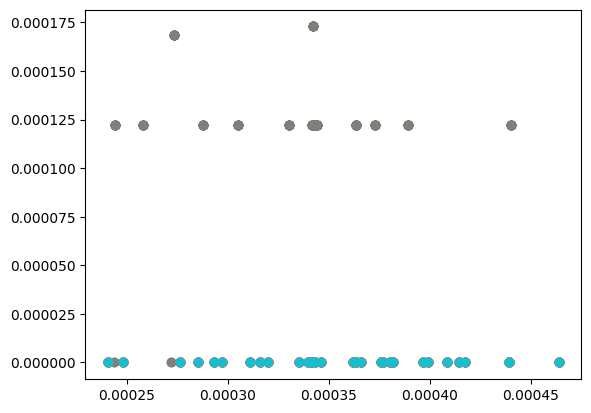

In [116]:
for i in labels: 
    plt.scatter((np.array(df_i[df_i['cluster']==i])[:,0]),(np.array(df_i[df_i['cluster']==i])[:,1]),label=i)
plt.show()

In [ ]:
plt.scatter(df_i[df_i['cluster']==0],)

In [270]:
### Mejorar clusters filtrando por categoría y subcategoría predicha

,price,centroid_name,centroid_brand,centroid_image,labelgroup
884,111111111.0,0.00021,0.0,0.09763,30309
